In [124]:
# IMPORT MODULES 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import numpy as np 
import datetime

In [125]:
# OPEN THE AASIAAT EGEDESMINDE MONTHLY TEMPERATURE CSV. SUBSET TO 1980-2023 AND REMOVE NaN VALUES (999.9)
ae_temperature = pd.read_csv('R:/JAKOBSHAVN/CODE/github/jakobshavn_isbrae/data/aasiaat_egedesminde_temps.csv')
ae_temperature = ae_temperature[(ae_temperature['YEAR'] >= 1980) & (ae_temperature['YEAR'] <= 2022)]
ae_temperature.replace(999.9, np.nan, inplace=True)

# CALCULATE MEAN MONTHLY TEMPERATURE BETWEEN 1980 AND 2018 
ae_temp_1980_2018 = ae_temperature[(ae_temperature['YEAR'] >= 1980) & (ae_temperature['YEAR'] <= 2017)]
mean_temp_1980_2018 = ae_temp_1980_2018[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].mean()

# FOR 2018-2023, CALCULATE THE MONTHLY ANOMALY, RELATIVE TO THE 1980-2018 MEAN
ae_temp_2018_to_2023 = ae_temperature[ae_temperature['YEAR'].isin([2018, 2019, 2020, 2021, 2022])]
anomaly_2018_2023 = ae_temp_2018_to_2023[['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].copy()
for month in ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']:
    anomaly_2018_2023[month] -= mean_temp_1980_2018[month]

# REFORMAT THE MONTH HEADINGS TO DATETIME OBJECTS 
months = pd.to_datetime(anomaly_2018_2023.columns[1:], format='%b')
anomaly_2018_2023.columns = ['YEAR'] + months.strftime('%b').tolist()

# FLATTEN THE DATAFRAME TO TWO COLUMNS (DATE AND ANOMALY)
anomaly_2018_2023 = pd.melt(anomaly_2018_2023, id_vars=['YEAR'], var_name='Month', value_name='Anomaly')
anomaly_2018_2023['DATE'] = pd.to_datetime(anomaly_2018_2023['YEAR'].astype(str) + '-' + anomaly_2018_2023['Month'], format='%Y-%b')
anomaly_2018_2023 = anomaly_2018_2023[['DATE', 'Anomaly']]
anomaly_2018_2023 = anomaly_2018_2023.sort_values(by='DATE')

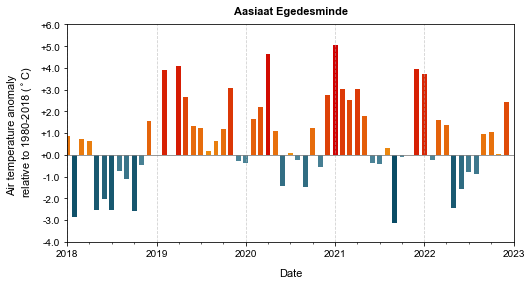

In [127]:
plt.rcParams["font.family"] = "Arial"
fig, ax = plt.subplots(figsize=(8, 4))
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8) 
plt.grid(axis = 'x', alpha=0.6, linestyle='--')
plt.title('Aasiaat Egedesminde', pad=10, fontsize=11, fontweight='bold')
plt.ylabel("Air temperature anomaly \n relative to 1980-2018 ($^\circ$C)", labelpad=6, fontsize=11)
plt.xlabel('Date', labelpad=10, fontsize=11)

# FORMAT THE X-AXIS TICK LIMITS  
year_locator = mdates.YearLocator(base=1, month=1, day=1)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
min_x_value = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
max_x_value = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
plt.xlim(min_x_value, max_x_value)
three_month_intervals = mdates.MonthLocator(interval=3)
ax.xaxis.set_minor_locator(three_month_intervals)

# SET THE Y AXIS TICK LIMITS, ADDING A '+' BEFORE POSITIVE VALUES 
plt.ylim(-4, 6)
plt.yticks(np.arange(-4, 6+1, 1))
def format_positive(value, tick_number):
    if value >= 0:
        return f'+{value:.1f}'
    else:
        return f'{value:.1f}'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_positive))

# DEFINE A CUSTOM BLUE & RED COLOUR MAP 
blue_cmap = LinearSegmentedColormap.from_list('custom_blue', ['#0a4c65', '#caf0f8'], N=256)
red_cmap = LinearSegmentedColormap.from_list('custom_red', ['#ffe81a', '#d00000'], N=256)
norm = plt.Normalize(anomaly_2018_2023['Anomaly'].min(), anomaly_2018_2023['Anomaly'].max())

# PLOT THE DATA WITH THE CUSTOM COLOUR MAPS
for index, row in anomaly_2018_2023.iterrows():
    anomaly_value = row['Anomaly']
    if not pd.isna(anomaly_value):
        color = red_cmap(norm(anomaly_value)) if anomaly_value >= 0 else blue_cmap(norm(anomaly_value))
        ax.bar(row['DATE'], anomaly_value, width=20, color=color)

plt.show()